# Contenido
## [Toda España](#1.0)
### [Casos confirmado totales](#1.1)
### [Casos confirmado por día](#1.2)
### [UCI totales](#1.3)
### [Fallecimientos totales](#1.4)
### [Fallecimientos por día](#1.5)
### [Factor crecimiento casos por día](#1.6)

## [Comunidades Autónomas](#2.0)
### [Casos confirmado totales](#2.1)
### [Casos confirmado por día](#2.2)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from scipy.optimize import curve_fit
from lmfit import Model

In [2]:
days_past = -2 # days beyond the start of the data to plot
days_future = 30 # days after the end of the data to predict and plot

myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
show_every = 2 # int value that defines how often to show a date in the x axis.

coeff_std = 1.1 # coefficient that defines how many standard deviations to use
coeff_std_d = 0.4

## Defining functions

In [3]:
def logistic(x, L, k, x0, y0):
    """ General Logistic function.
    Args:
        x    float or array-like, it represents the time
        L    float, the curve's maximum value
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the sigmoid's midpoint
        y0   float, curve's shift in the y axis """
    y = L / (1 + np.exp(-k*(x-x0))) + y0
    return y

In [4]:
def logistic_derivative(x, L, k, x0):
    """ General Gaussian like function (derivative of the logistic).
    Args:
        x    float or array-like, it represents the time
        L    float, the curve's integral (area under the curve)
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the max value """
    y = k * L * (np.exp(-k*(x-x0))) / np.power(1 + np.exp(-k*(x-x0)), 2)
    return y

In [5]:
def fit_curve(curve, dates, ydata, title, ylabel, coeff_std):
    if curve.__name__ == 'logistic':
            p0=[20000, 0.5, 1, 0]
            bounds=([0, 0, 0, 0], [300000, 10, 100, 1])
            params_names = ['L', 'k', 'x0', 'y0']
    elif curve.__name__ == 'logistic_derivative':
            p0=[20000, 0.5, 1]
            bounds=([0, 0, 0], [200000, 10, 100])
            params_names = ['L', 'k', 'x0']
    else:
            print('this curve is unknown')
    
    myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
    show_every = 3 # int value that defines how often to show a date in the x axis.
    
    # Create x-var in dates and as a float array to the fit
    xdata=(dates-dates[0]).astype('timedelta64[D]').astype('float')
    dates_xdata=dates
    
    future_axis = np.arange(1,days_future+1) + xdata[-1]
    dates_future_axis = dates_xdata[0]+future_axis.astype('timedelta64[D]')
    
    total_xaxis = np.concatenate((np.arange(-days_past,0),xdata,future_axis))
    dates_total_xaxis = dates_xdata[0]+total_xaxis.astype('timedelta64[D]')
    
    # Optimize fit
    popt, pcov = curve_fit(curve, xdata, ydata, p0 = p0, bounds = bounds)
    perr = np.sqrt(np.diag(pcov))
    pworst = popt + coeff_std*perr
    pbest = popt - coeff_std*perr
    
    # LSQ fit
    gmodel = Model(curve)
    if curve.__name__ == 'logistic':
        result = gmodel.fit(ydata, x=xdata, L=p0[0], k=p0[1], x0=p0[2], y0=p0[3])
    elif curve.__name__ == 'logistic_derivative':
        result = gmodel.fit(ydata, x=xdata, L=p0[0], k=p0[1], x0=p0[2])
        
    # Create titles
    descr = 'Fit parameters: '
    descrE = '1-SD error for fit params: ' 
    for i, param in enumerate(params_names):
        descr = descr + "{}={:.3f}".format(param, popt[i])
        if i < len(params_names) - 1:
            descr = descr + ', '
    for i, param in enumerate(params_names):
        descrE = descrE + "{}={:.3f}".format(param, perr[i])
        if i < len(params_names) - 1:
            descrE = descrE + ', '        
    
    ## figure
    fig, ax = plt.subplots(figsize = (15, 8))
    fig.autofmt_xdate()
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    ax.plot(dates_total_xaxis, curve(total_xaxis, *popt), 'r-', linewidth=4, label='fit')
    ax.plot(dates, result.best_fit, 'yo', label='best fit')
    ax.bar(dates,ydata, label='data')
    
    ax.fill_between(dates_future_axis, curve(future_axis, *pbest), 
                                       curve(future_axis, *pworst), facecolor='red', alpha=0.2, label='std')
    
    ax.set_xticks(dates_total_xaxis[::show_every])
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title('{} \n {}'.format(descr,descrE))
    ax.set_ylim(bottom=0)
    ax.legend(loc='upper left')
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid(True)

    return popt, perr

In [6]:
def exp2(x, x0, Td):
    """ exponential function (base 2).
    Args:
        x    float or array-like, it represents the time
        Td   doubling time
        x0   float, the x-value where the funtion is 1 """
    return 2 ** ((x - x0) / Td)

## Reading data
Los datos son obtenidos, diariamente, del Minsiterio de Sanidad en su página web, y son convertidos de los PDF a csv para poder ser analizados. Estos datos son convertidos por https://github.com/victorvicpal/COVID19_es

Las fechas corresponde a la emisión de informe del *Centro de Coordinación de Alertas y Emergencias Sanitarias*, que indica los casos consolidados a las 21:00 del día previo

In [7]:
data = pd.read_csv('../data/final_data/dataCOVID19_es.csv')
Spain = data.groupby('fecha', as_index=False).sum()

In [8]:
Confirmed = Spain.casos.values
UCI=Spain.UCI.values
Deaths = Spain.muertes.values
dates = pd.to_datetime(Spain.fecha.values).to_numpy()

#There was a gap on the reports in the 7/03 and 08/03
ind=np.where( (dates != np.datetime64(datetime(2020, 3, 7))) & (dates != np.datetime64(datetime(2020, 3, 8))))
Confirmed=Confirmed[ind]
UCI=UCI[ind]
Deaths=Deaths[ind]
dates=dates[ind]

In [9]:
## Add data before it was segregatted by Region
Confirmed=np.insert(Confirmed,0,[16,32])
Deaths=np.insert(Deaths,0,[0,0])
UCI=np.insert(UCI,0,[0,0])
dates=np.insert(dates,0,[np.datetime64(datetime(2020,2,27)), np.datetime64(datetime(2020,2,28))])

# Toda España  <a class="anchor" id="1.0"></a>
## Casos confirmados totales <a class="anchor" id="1.1"></a>
Casos para toda España confirmados, ajustados a una curva logística. Es una curva acumulada, de modo que el valor para el ultimo dia con datos corresponde a todos los casos qye ha en España y que han sido confirmados analíticamente.

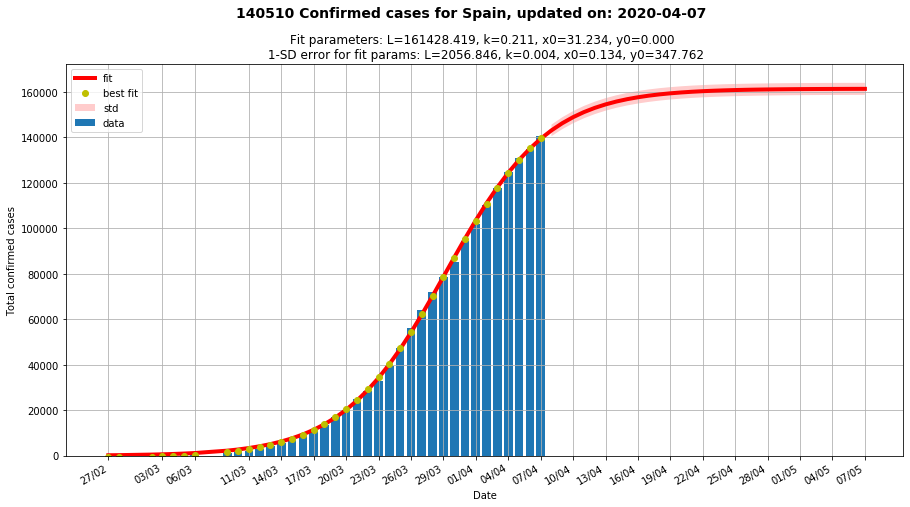

In [10]:
Titulo = '{:.0f} Confirmed cases for Spain, updated on: {}'.format(Confirmed[-1],dates[-1].astype('datetime64[D]'))
p_cont, err_cont = fit_curve(logistic, dates, Confirmed, Titulo, 'Total confirmed cases', coeff_std)

### Ajuste de tiempo de duplicacion de casos confirmados

In [11]:
xdata = (dates-dates[0]).astype('timedelta64[D]').astype('float')
ydata = Confirmed

future_axis = np.arange(1,days_future+1) + xdata[-1]
dates_future_axis = dates[0]+future_axis.astype('timedelta64[D]')
    
total_xaxis = np.concatenate((np.arange(-days_past,0),xdata,future_axis))
dates_total_xaxis = dates[0]+total_xaxis.astype('timedelta64[D]')

p0=[0, 2]
bounds=([-10000, 1], [10, 10])
params_names = ['x0', 'Td']

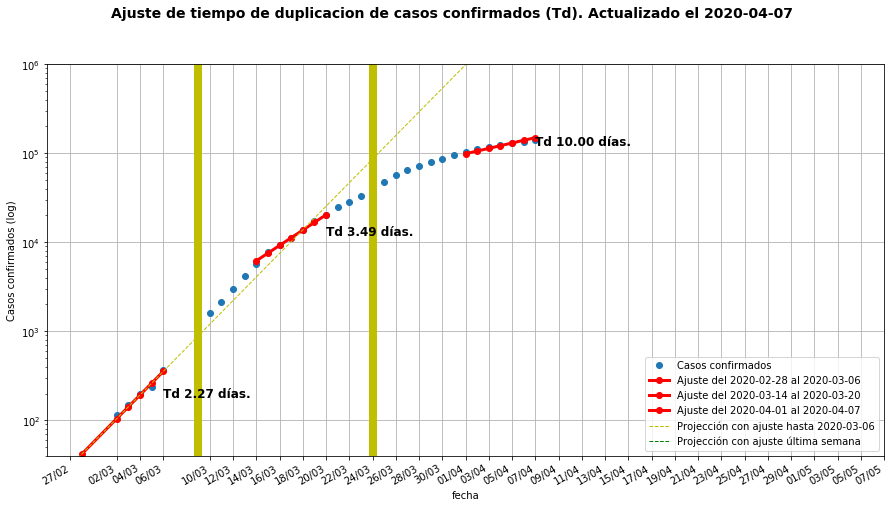

In [12]:
Lsta=[1,12,np.size(xdata)-7]
Lsto=[7,19,np.size(xdata)]

pcov=[]
popt=[]
Td=[]
L=[]

for ind in range(len(Lsto)):
    X=xdata[Lsta[ind]:Lsto[ind]]
    Y=ydata[Lsta[ind]:Lsto[ind]]
    opt_temp, cov_temp = curve_fit(exp2, X, Y, p0 = p0, bounds = bounds)
    pcov.append(cov_temp)
    popt.append(opt_temp)
    L.append('Ajuste del {} al {}'.format(dates[Lsta[ind]].astype('datetime64[D]'),dates[Lsto[ind]-1].astype('datetime64[D]')))
    Td.append('Td {:.2f} días.'.format(opt_temp[1]))

fig, ax = plt.subplots(figsize=(15,8))
fig.autofmt_xdate()
fig.suptitle('Ajuste de tiempo de duplicacion de casos confirmados (Td). Actualizado el {}'.
             format(dates[-1].astype('datetime64[D]')),fontsize=14, fontweight='bold')
ax.plot(dates,ydata, 'o',label='Casos confirmados')


for ind in range(len(Lsto)):
    ax.plot(dates[Lsta[ind]:Lsto[ind]], exp2(xdata[Lsta[ind]:Lsto[ind]], *popt[ind]), 'ro-', 
        linewidth=3, label=L[ind])
    ax.text(dates[Lsto[ind]-1],np.mean(ydata[Lsta[ind]:Lsto[ind]]),Td[ind], 
        fontsize=12, fontweight='bold')


ax.plot(dates,        exp2(xdata,        *popt[0]), 'y--', 
        linewidth=1, label='Projección con ajuste hasta {}'.format(dates[Lsto[0]-1].astype('datetime64[D]')))

ax.plot(dates,        exp2(xdata,   x0=popt[0][0], Td=popt[-1][1]), 'g--', 
        linewidth=1, label='Projección con ajuste última semana')

ax.plot([dates[7],dates[7]],[1,1000000],'y',linewidth=8)
ax.plot([dates[22],dates[22]],[1,1000000],'y',linewidth=8)

ax.legend(loc='lower right')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.set_ylabel('Casos confirmados (log)')
ax.set_xlabel('fecha')
ax.set_yscale('log')
ax.grid(True)
ax.set_ylim([40, 1000000])      
ax.set_xticks(dates_total_xaxis[::2]);   

### Tiempos de duplicación de casos confirmados
Calculado en el periodo de los 4 días previos y el día del informe del CNE-ISCIII

In [23]:
STd=[]
dates_STd=[]
for i1 in range(6,np.size(xdata)):
    X=xdata[i1-6:i1]
    Y=ydata[i1-6:i1]
    opt_temp, cov_temp = curve_fit(exp2, X, Y, p0 = p0, bounds = bounds)
    STd.append(opt_temp[1])
    dates_STd.append(dates[i1-1])

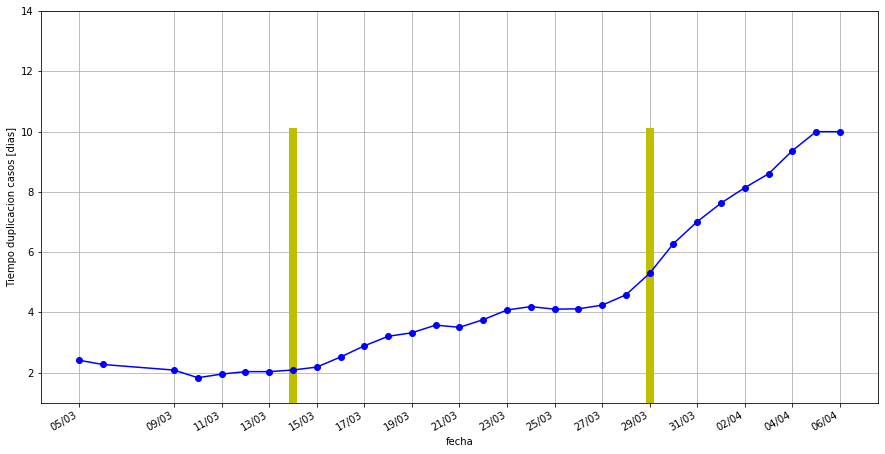

In [24]:
fig, ax = plt.subplots(figsize=(15,8))
fig.autofmt_xdate()
ax.plot([dates_STd[7],dates_STd[7]],[1,10],'y',linewidth=8)
ax.plot([dates_STd[22],dates_STd[22]],[1,10],'y',linewidth=8)
ax.plot(dates_STd,STd,'bo-')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.set_xlabel('fecha')
ax.set_ylabel('Tiempo duplicacion casos [dias]')
ax.grid(True)
ax.set_ylim([1,14])      
ax.set_xticks(dates_STd[::2]);   

## Nuevos casos por día <a class="anchor" id="1."></a>
Nuevos casos notificadasos cada día, según la fecha de notificación, y ajustados a una gaussiana.

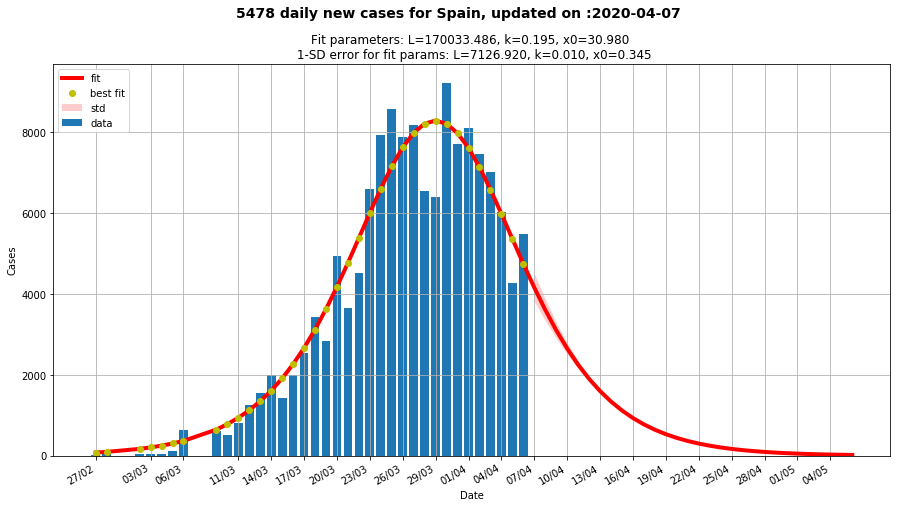

In [25]:
newCases=np.diff(Confirmed)

Titulo = '{:.0f} daily new cases for Spain, updated on :{}'.format(newCases[-1],dates[-1].astype('datetime64[D]'))
p_cont, err_cont = fit_curve(logistic_derivative, dates[:-1], newCases, Titulo, 'Cases', coeff_std)

## UCI <a class="anchor" id="1.3"></a>

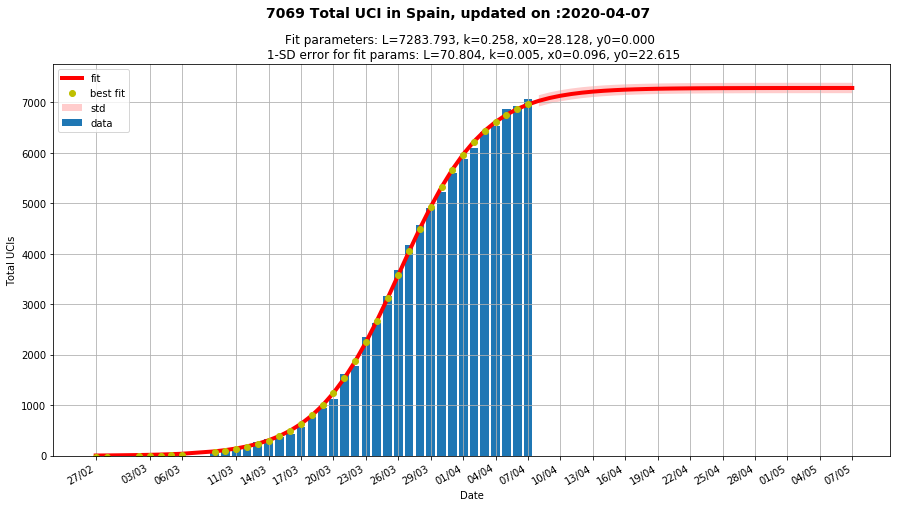

In [26]:
Titulo = '{:.0f} Total UCI in Spain, updated on :{}'.format(UCI[-1],dates[-1].astype('datetime64[D]'))
p_cont, err_cont = fit_curve(logistic, dates, UCI, Titulo, 'Total UCIs', coeff_std)

## Fallecimientos totales <a class="anchor" id="1.4"></a>

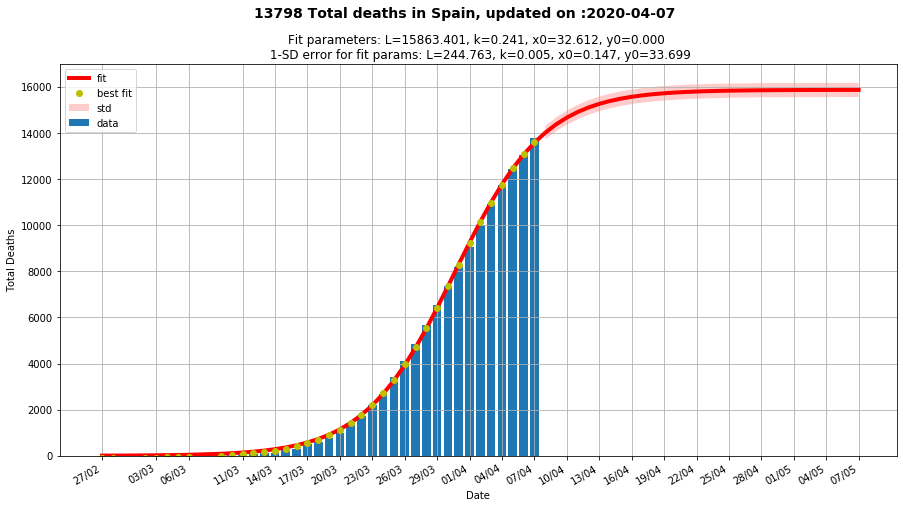

In [27]:
Titulo = '{:.0f} Total deaths in Spain, updated on :{}'.format(Deaths[-1],dates[-1].astype('datetime64[D]'))
p_cont, err_cont = fit_curve(logistic, dates, Deaths, Titulo, 'Total Deaths', coeff_std)

## Fallecimientos por día <a class="anchor" id="1.5"></a>

Fallecimientos totales en España por día, ajustados a una gaussiana.

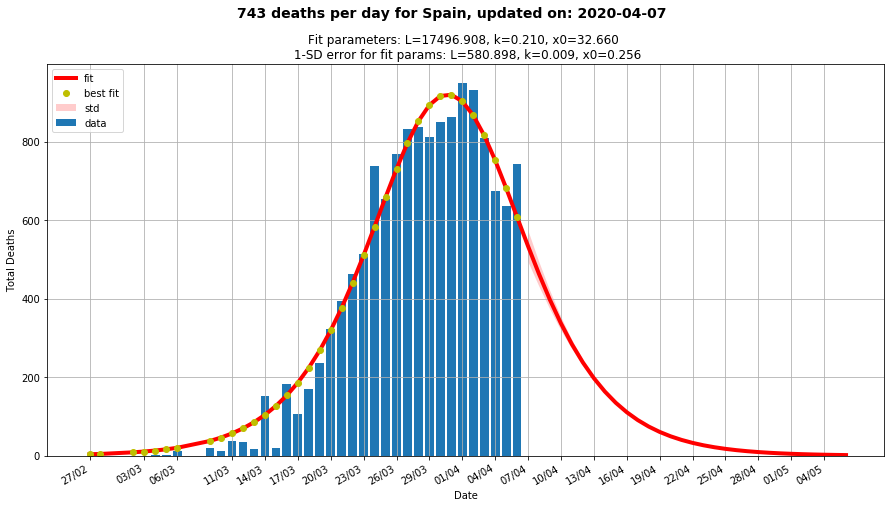

In [28]:
deathsPerDay=np.diff(Deaths)

Titulo = '{:.0f} deaths per day for Spain, updated on: {}'.format(deathsPerDay[-1],dates[-1].astype('datetime64[D]'))
p_cont, err_cont = fit_curve(logistic_derivative, dates[:-1], deathsPerDay, Titulo, 'Total Deaths', coeff_std)

## Factor de crecimiento diario en el número de casos <a class="anchor" id="1.6"></a>

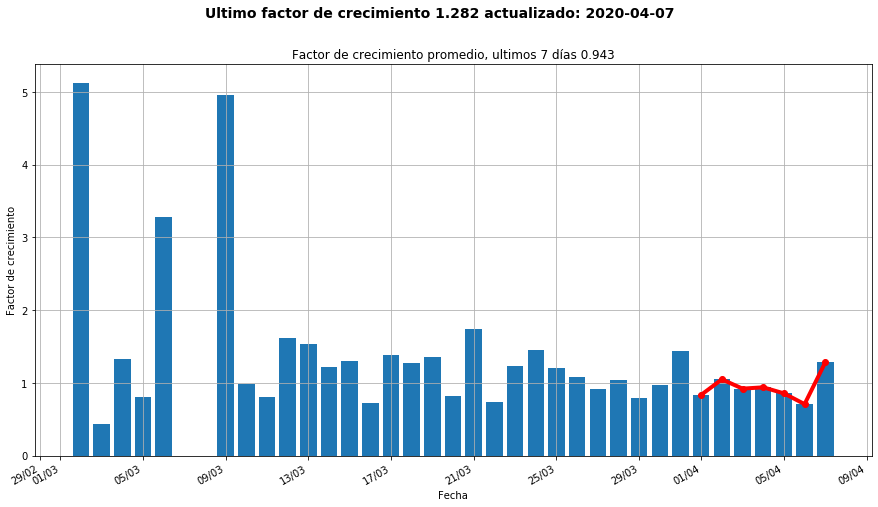

In [29]:
tempVar=np.diff(Confirmed)
tempVar[tempVar==0]=np.nan
newCases=tempVar
datesNewCases=dates[1:]

growth_factor = newCases[1:] / newCases[:-1]
dates_growth_factor = datesNewCases[1:]

fig, ax = plt.subplots(figsize=(15,8))
fig.autofmt_xdate()
Titulo = 'Ultimo factor de crecimiento {:.3f} actualizado: {}'.format(growth_factor[-1],dates[-1].astype('datetime64[D]'))
fig.suptitle(Titulo, fontsize=14, fontweight='bold')

ax.bar(dates_growth_factor,growth_factor )
ax.plot(dates_growth_factor[-7:],growth_factor[-7:],'ro-', linewidth=4,)
Titulo2 = 'Factor de crecimiento promedio, ultimos 7 días {:.3f}'.format(np.mean(growth_factor[-7:]))
ax.set_title(Titulo2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Factor de crecimiento')
ax.xaxis.set_major_formatter(myFmt)
ax.grid(True)

# Por comunidades autónomas<a class="anchor" id="2.0"></a>
## Casos confirmados totales <a class="anchor" id="2.1"></a>

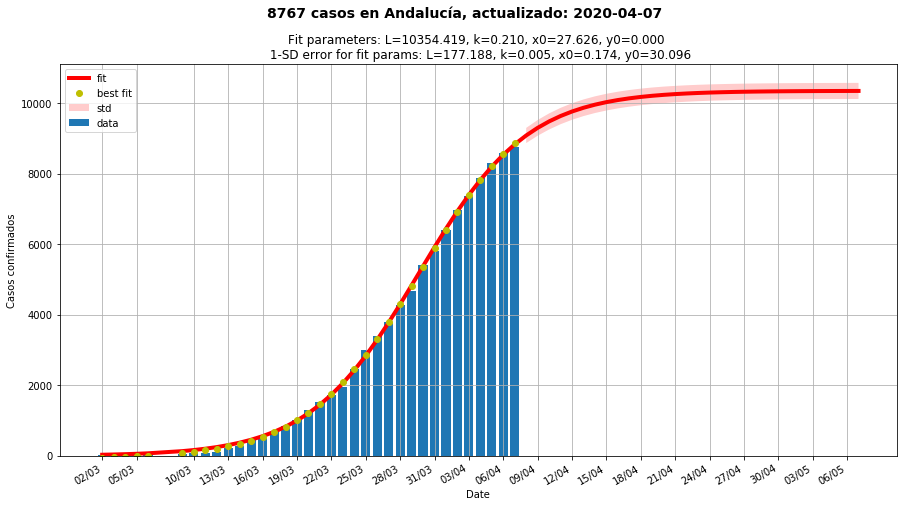

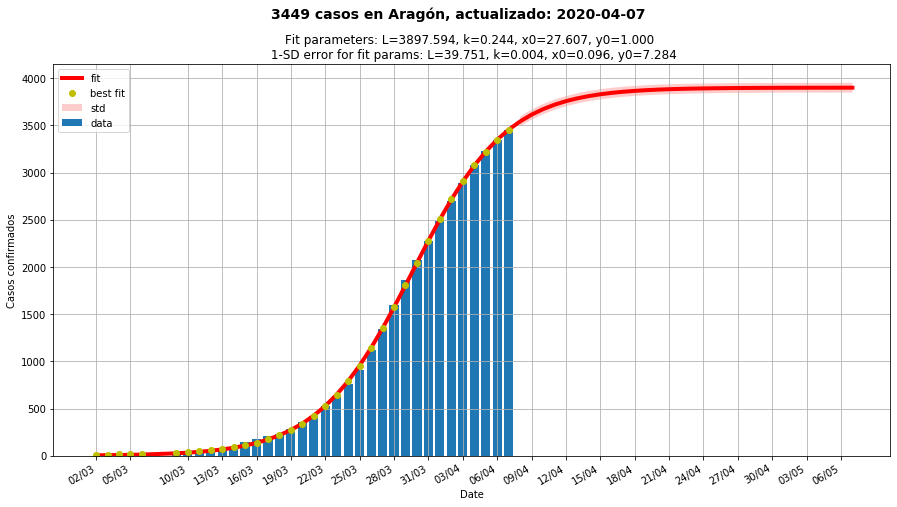

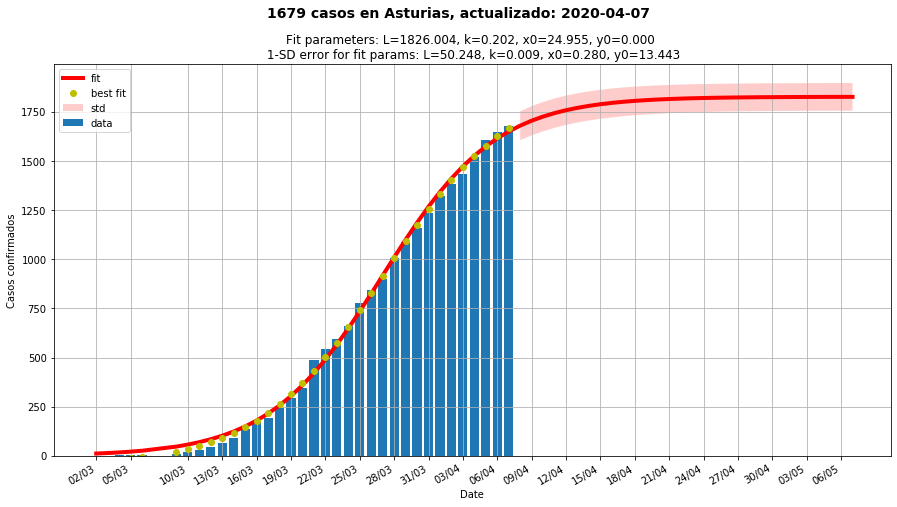

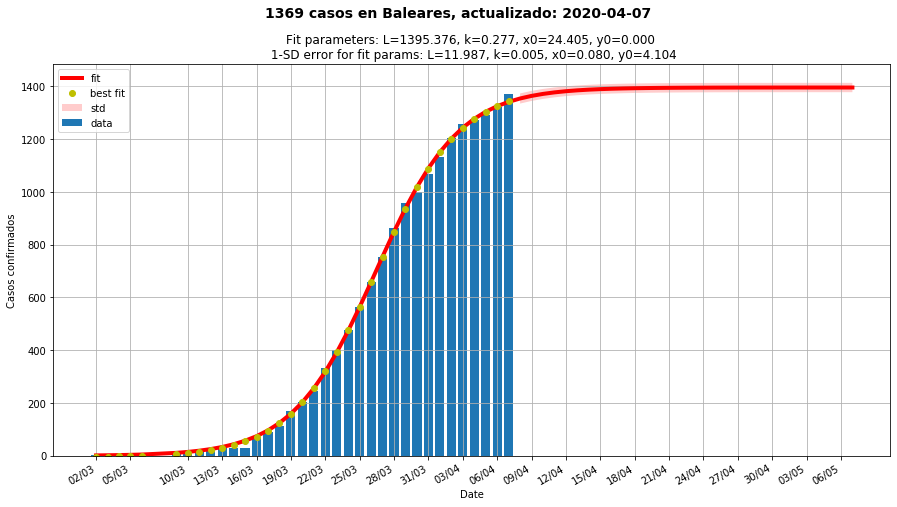

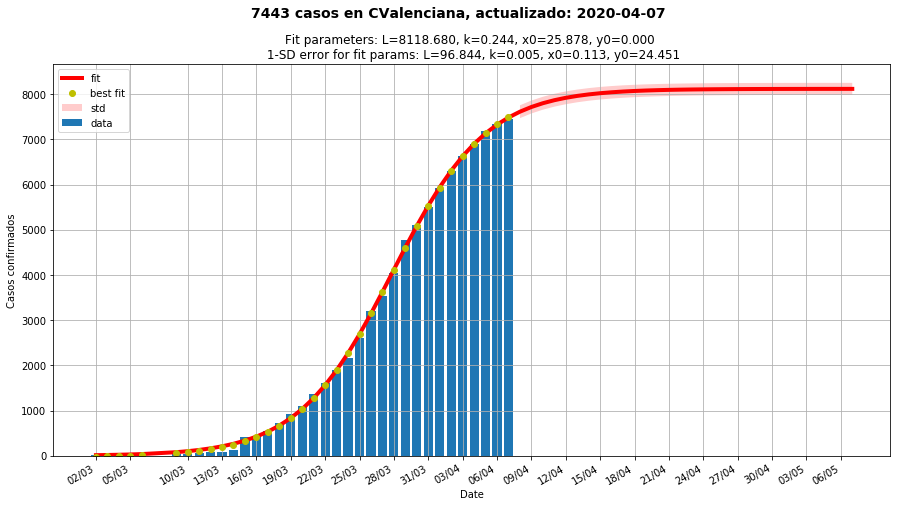

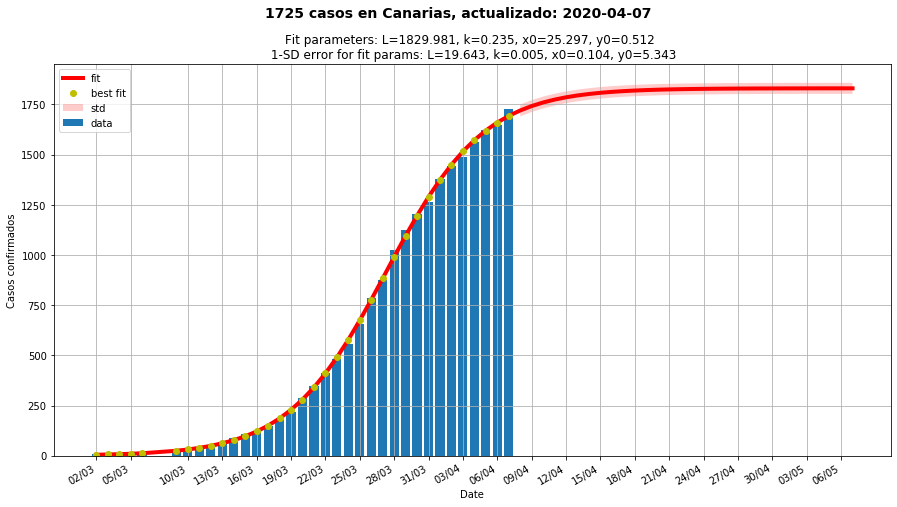

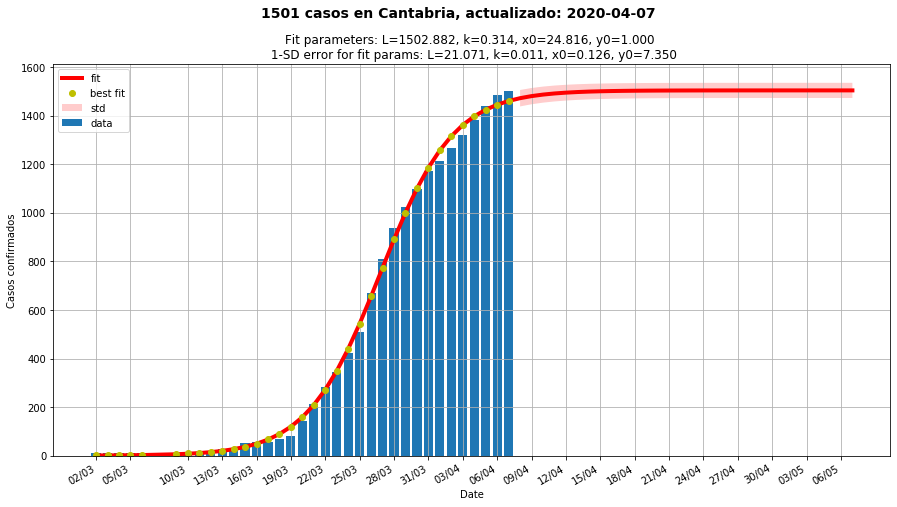

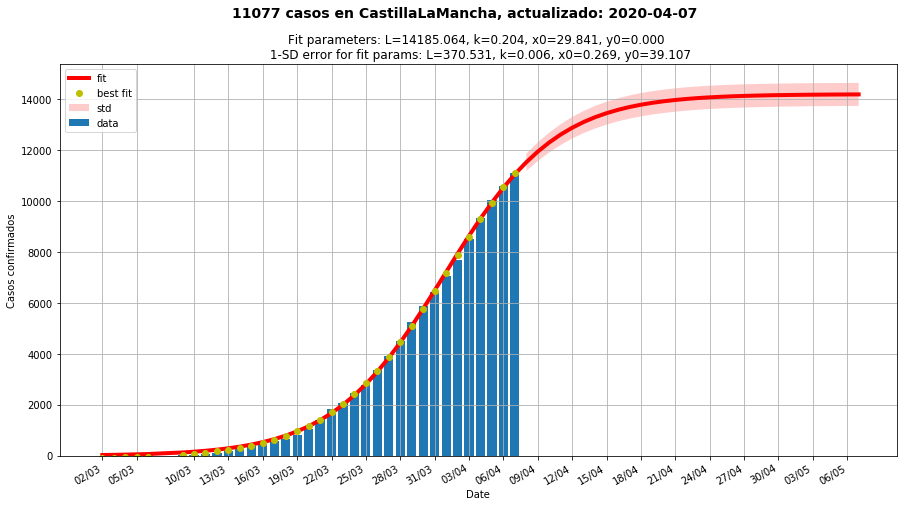

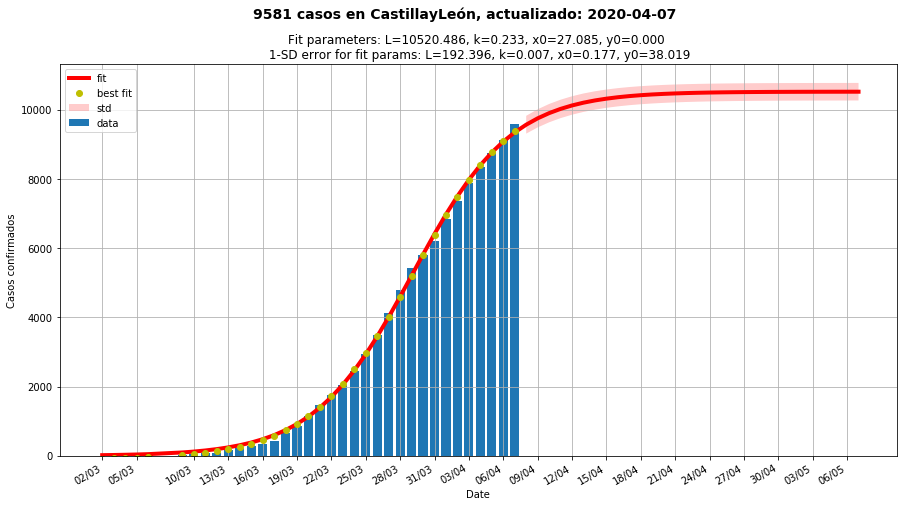

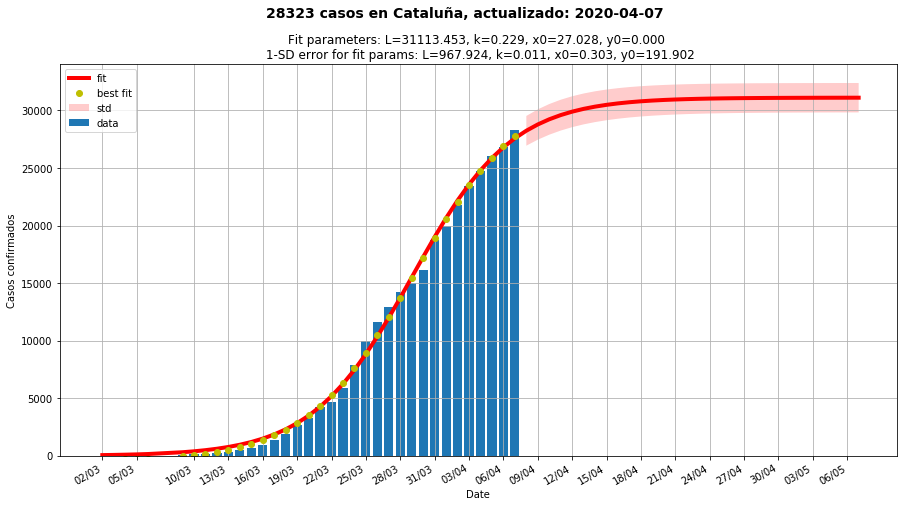

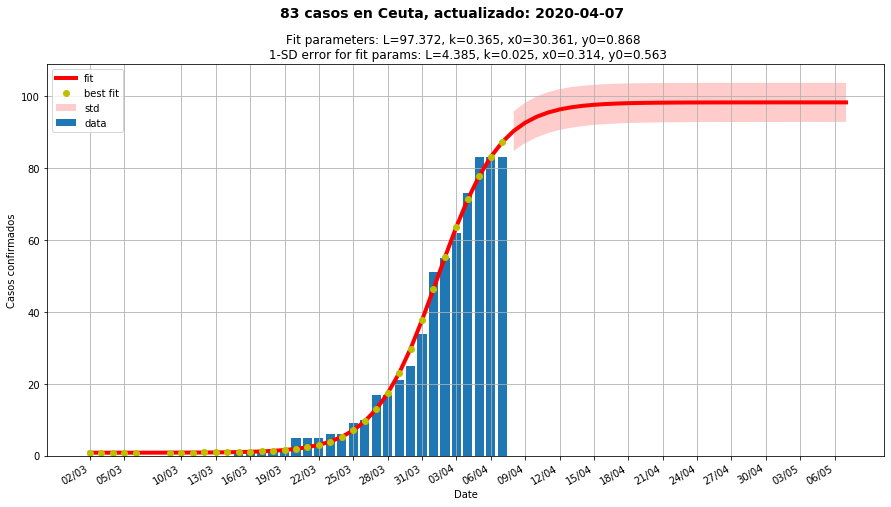

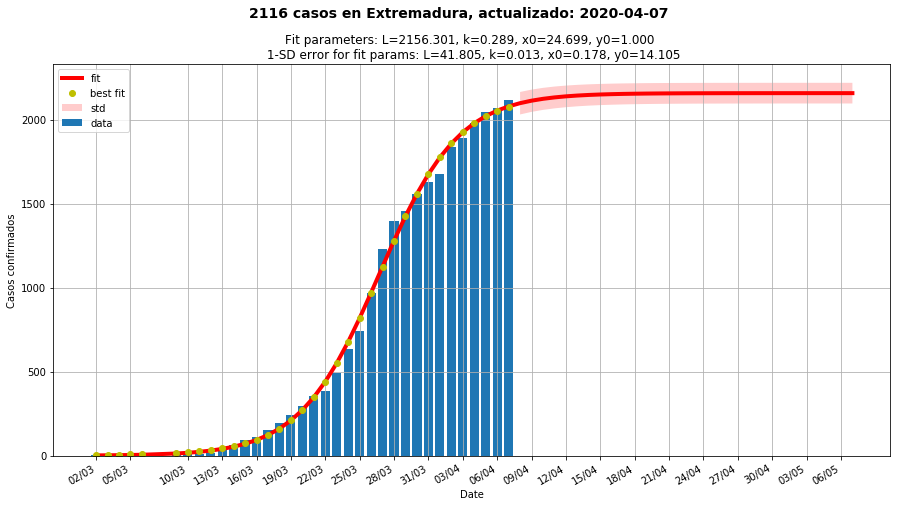

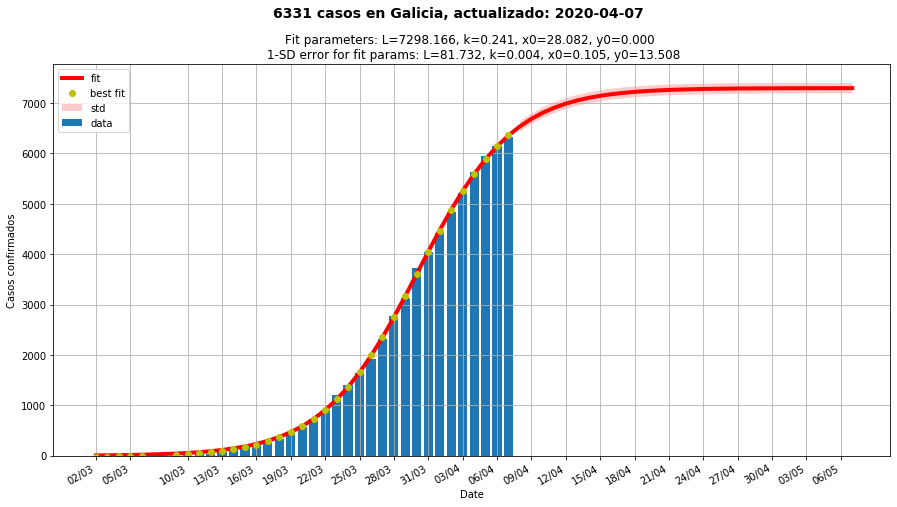

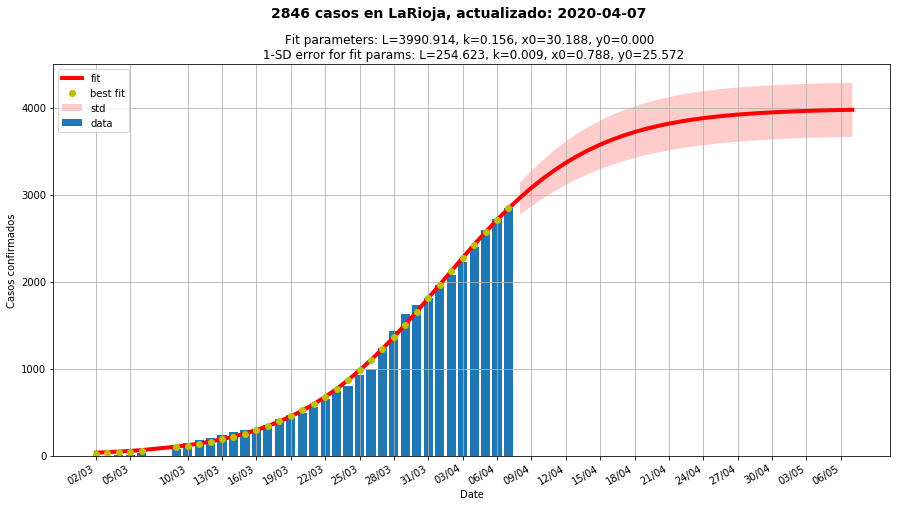

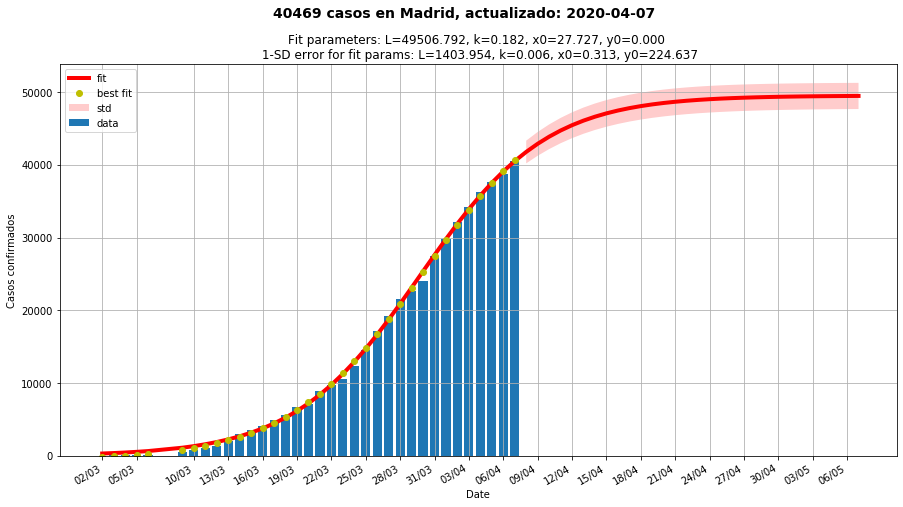

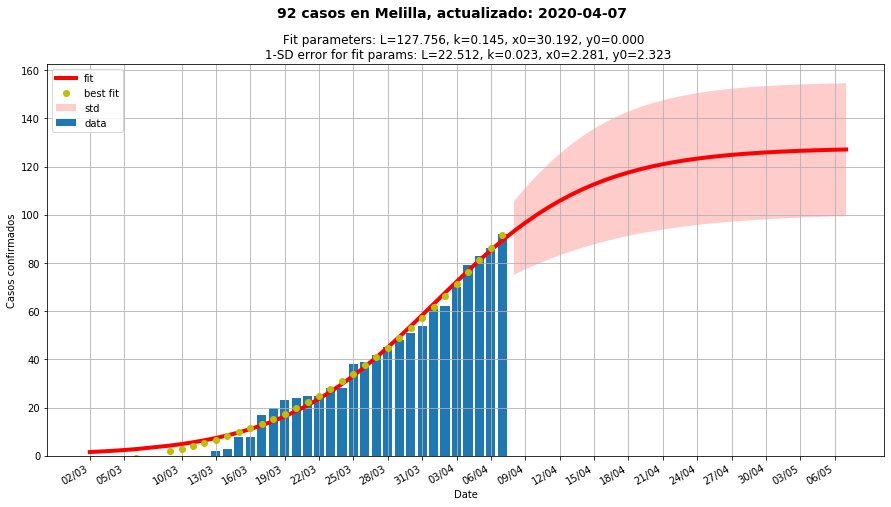

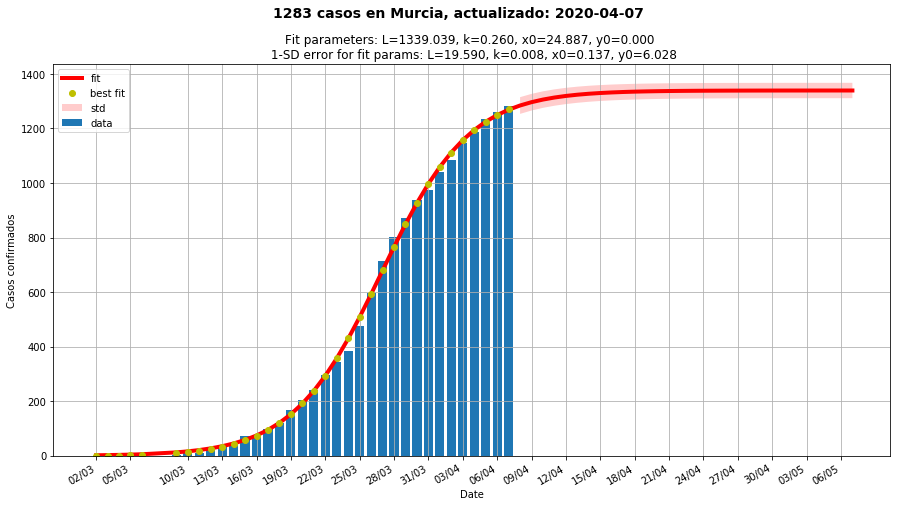

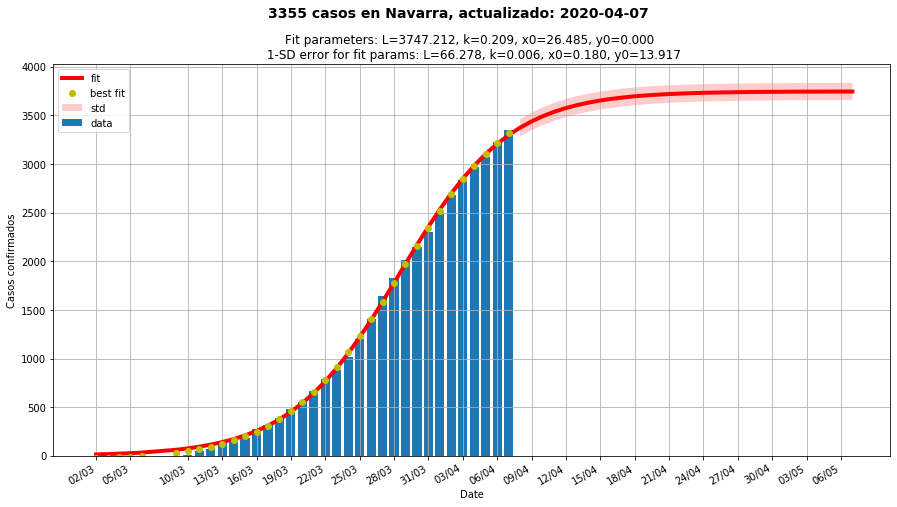

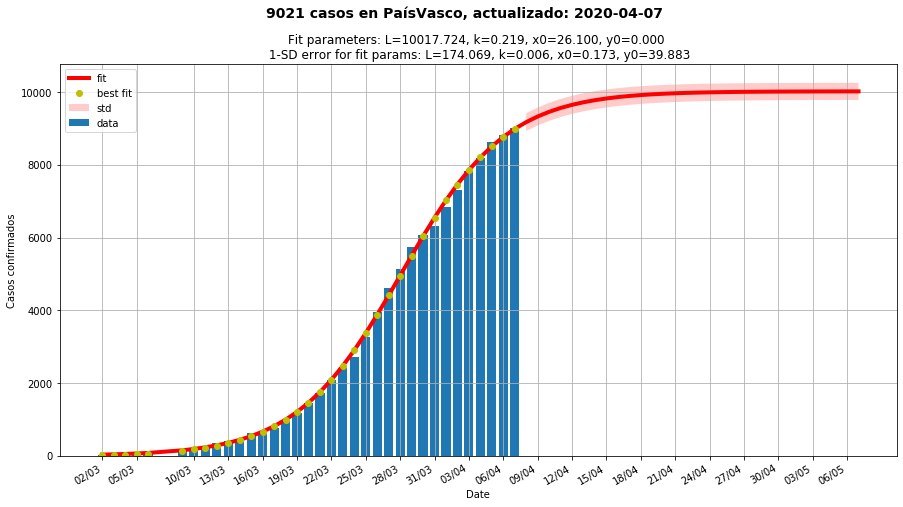

In [20]:
for CCAA in data.CCAA.unique():
    ConfirmedCCAA = data[data.CCAA==CCAA].casos.values
    datesCCAA = pd.to_datetime(data[data.CCAA=='Canarias'].fecha).to_numpy()
    
    #There was a gap on the reports in the 7/03 and 08/03
    ind=np.where( (datesCCAA != np.datetime64(datetime(2020, 3, 7))) & (datesCCAA != np.datetime64(datetime(2020, 3, 8))))   
    ConfirmedCCAA = ConfirmedCCAA[ind]
    datesCCAA = datesCCAA[ind]
    newCasesCCAA = np.diff(ConfirmedCCAA)
    
    Titulo = '{:.0f} casos en {}, actualizado: {}'.format(ConfirmedCCAA[-1],CCAA,datesCCAA[-1].astype('datetime64[D]'))
    p_cont, err_cont = fit_curve(logistic, datesCCAA,  ConfirmedCCAA, Titulo, 'Casos confirmados', coeff_std)


## Nuevos casos por CCAA <a class="anchor" id="2.2"></a>

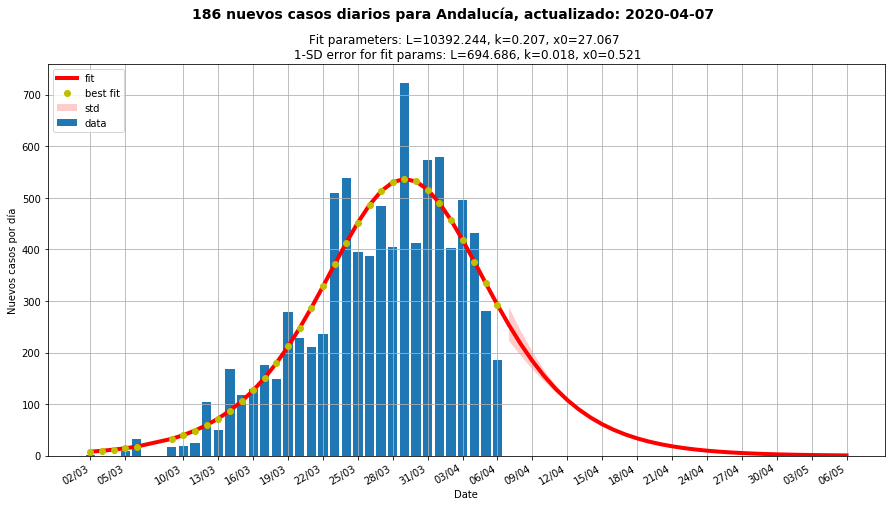

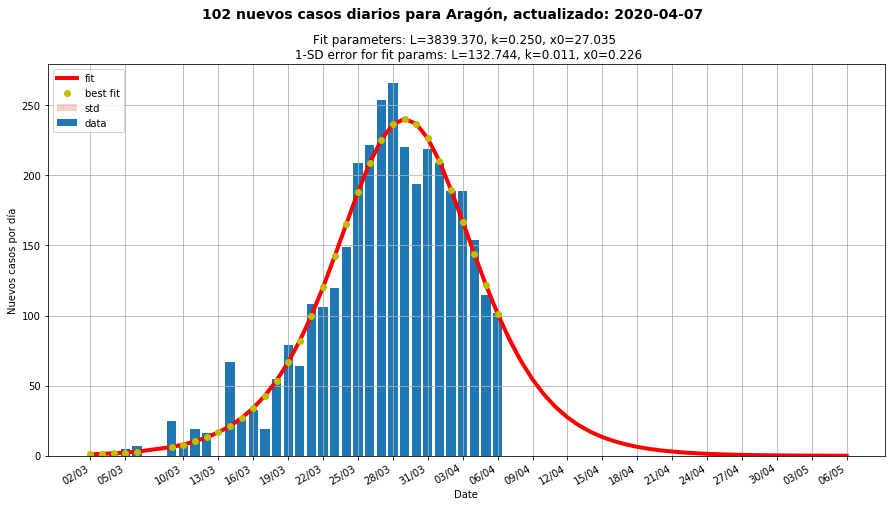

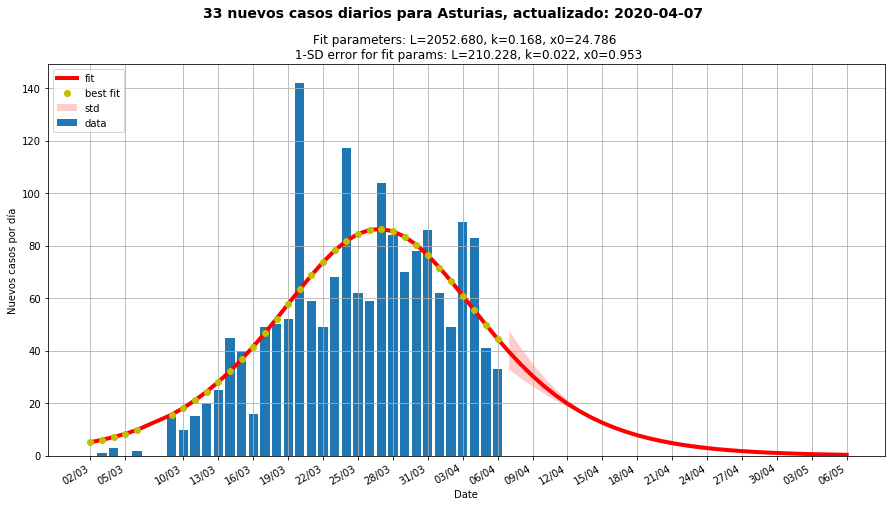

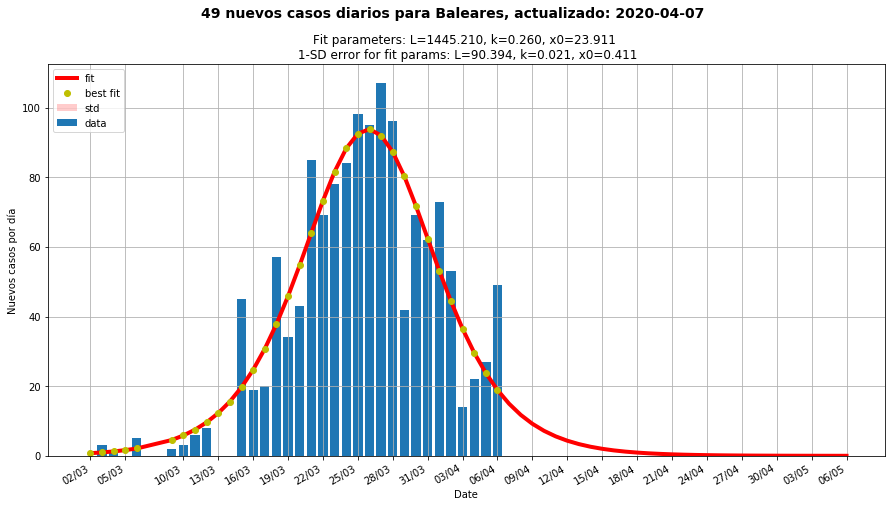

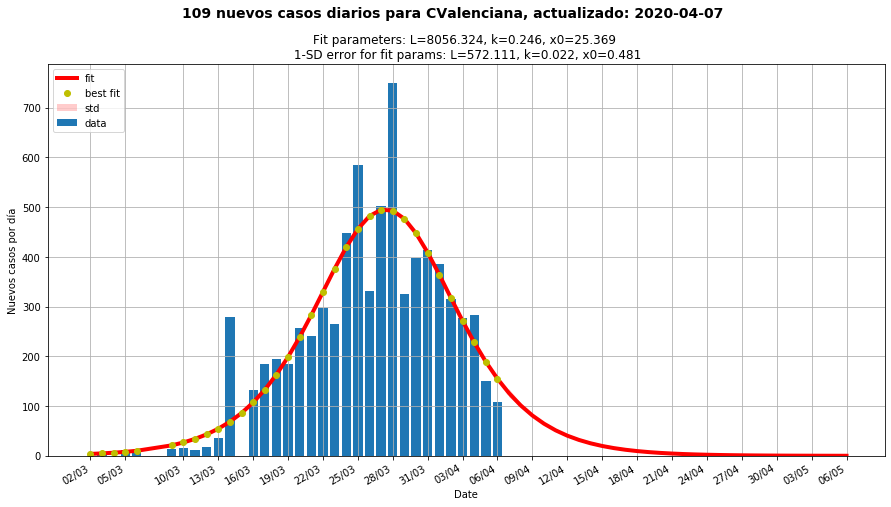

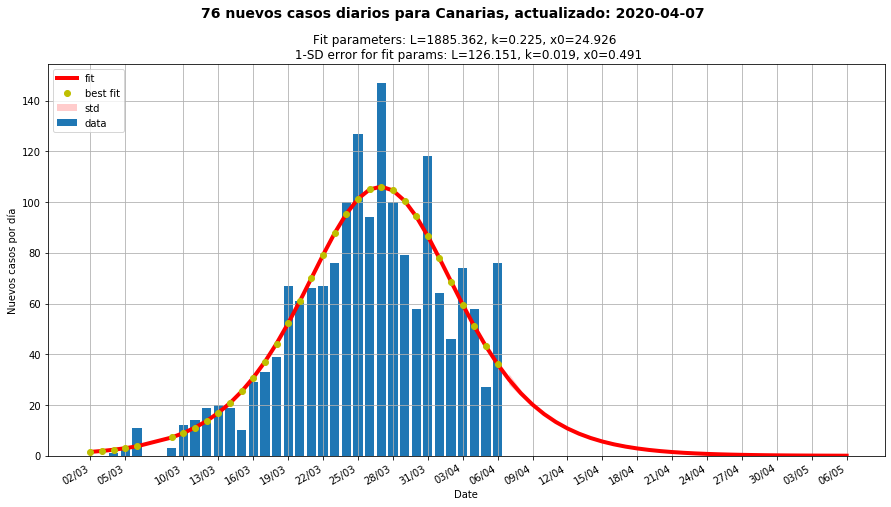

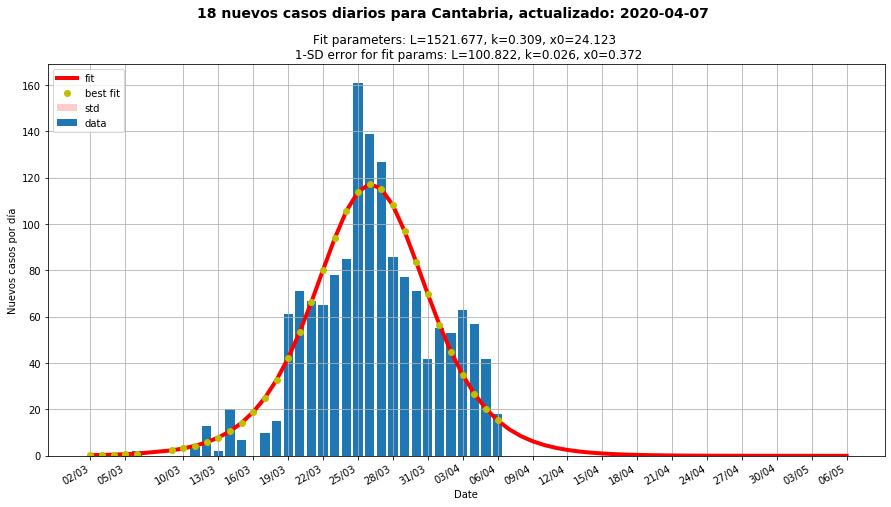

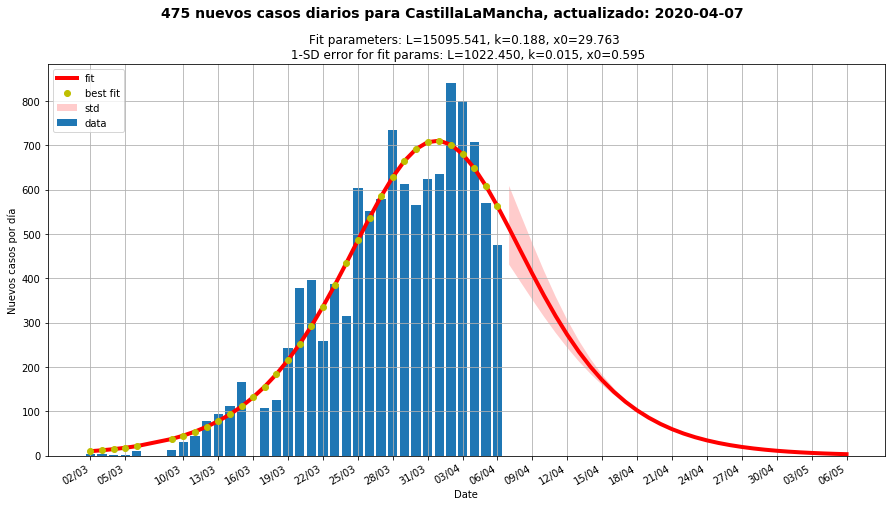

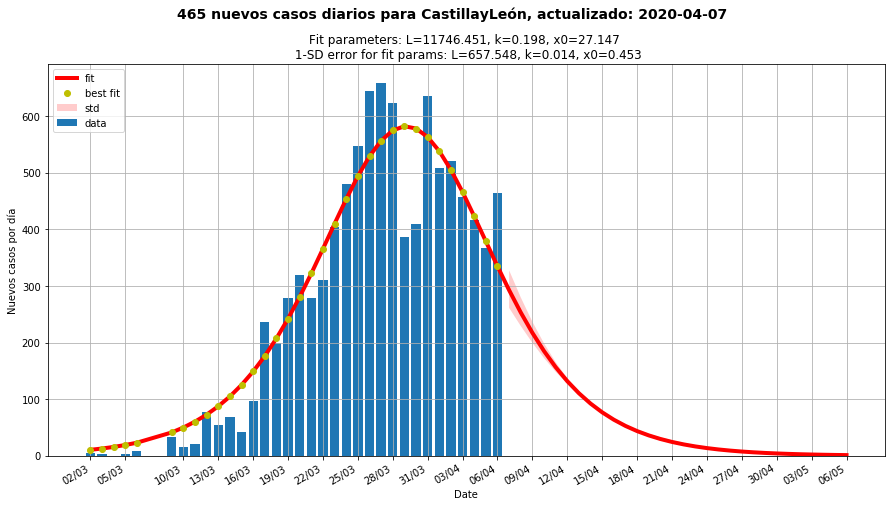

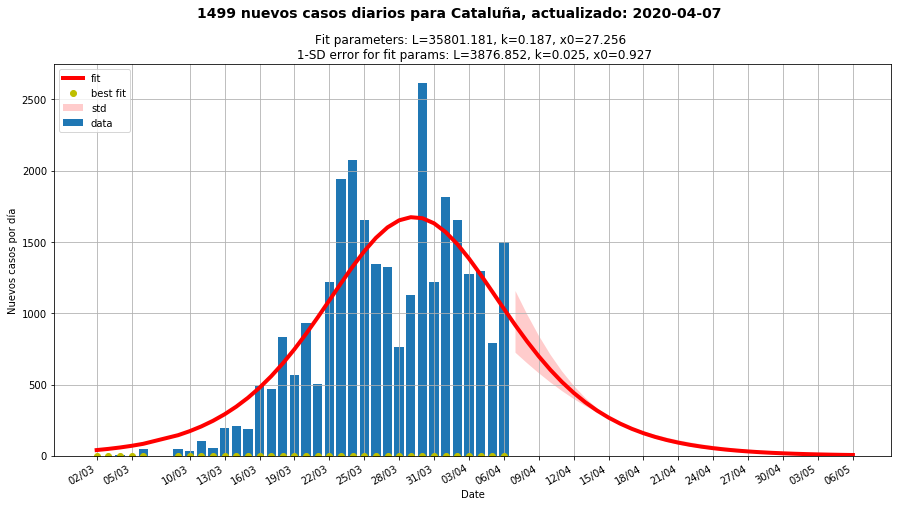

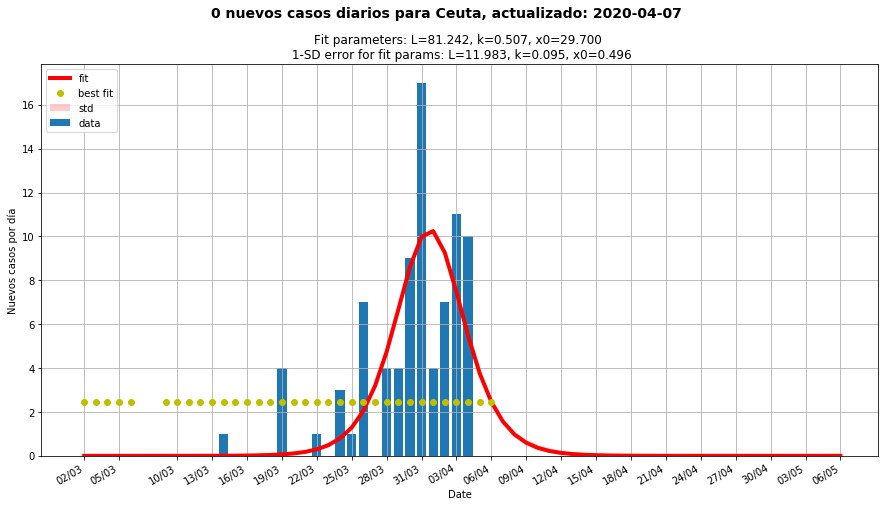

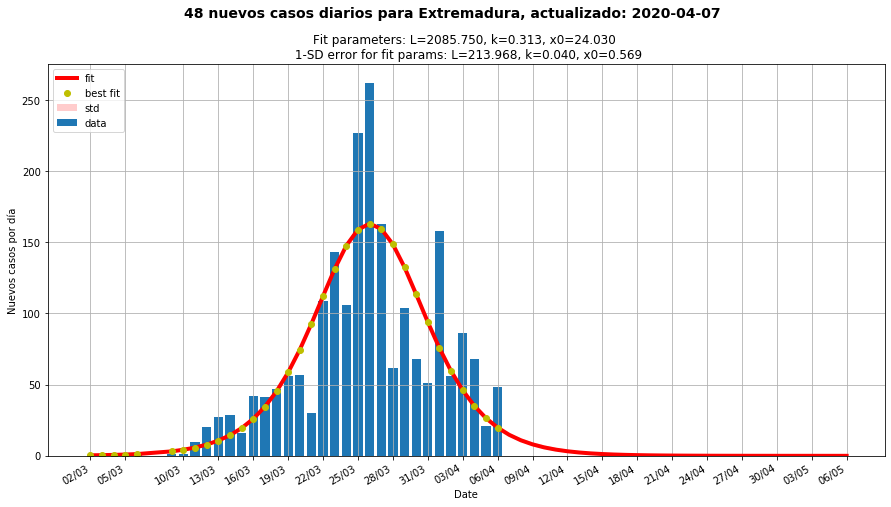

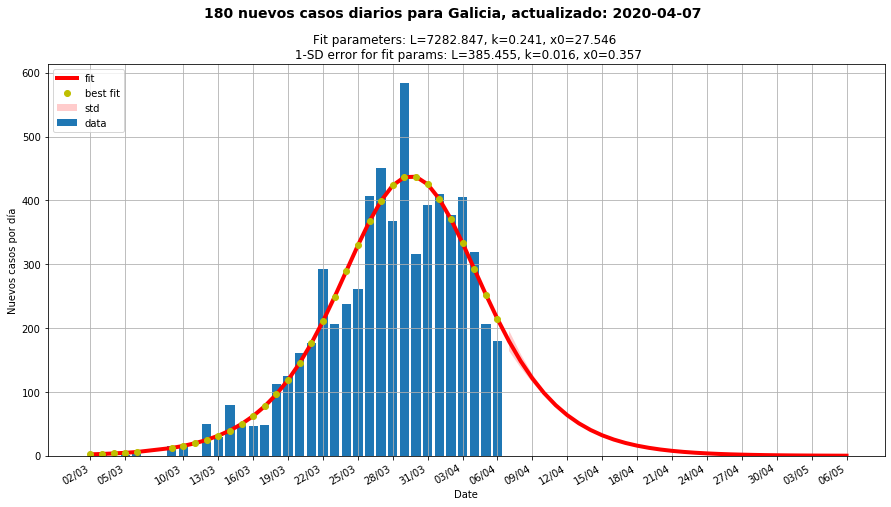

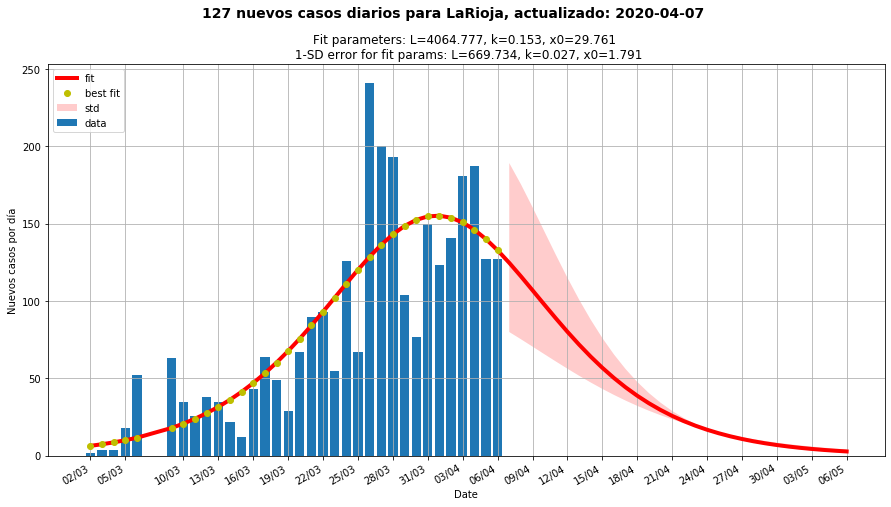

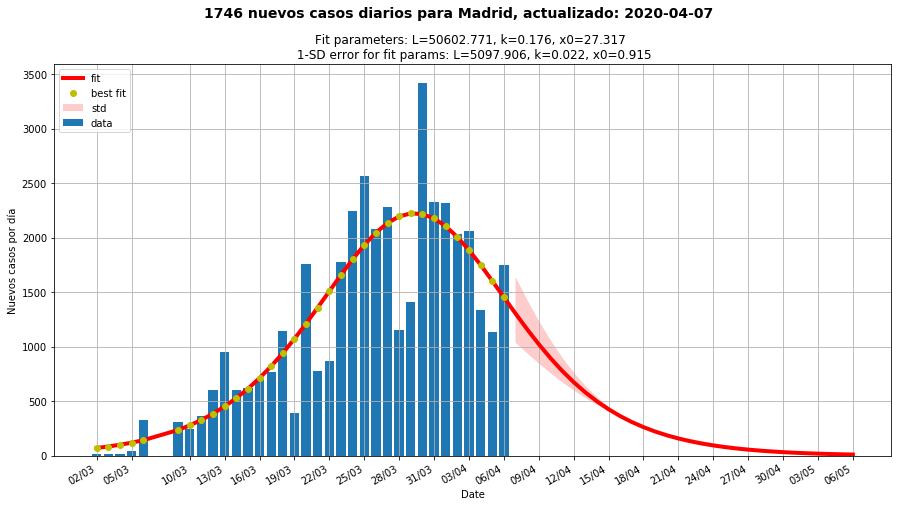

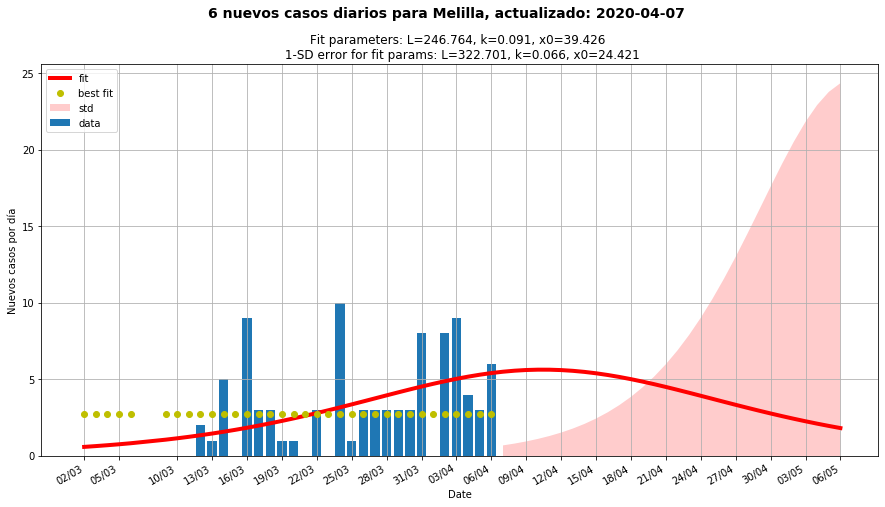

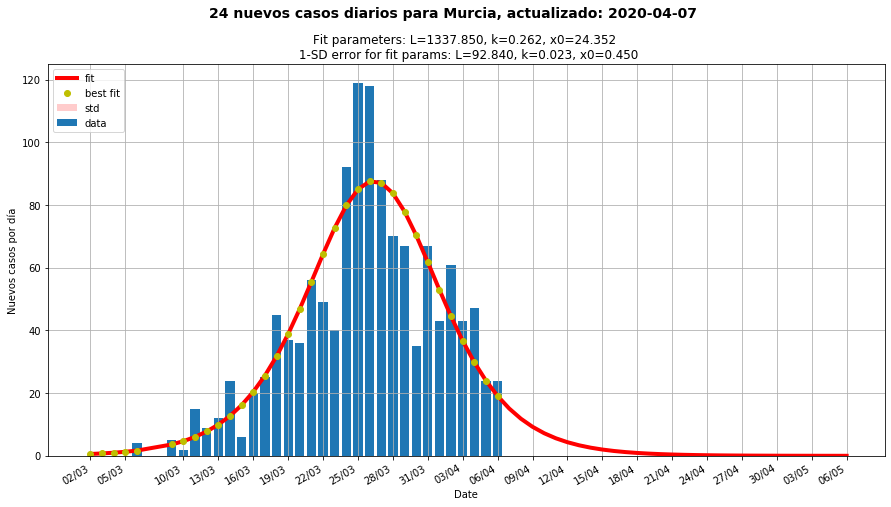

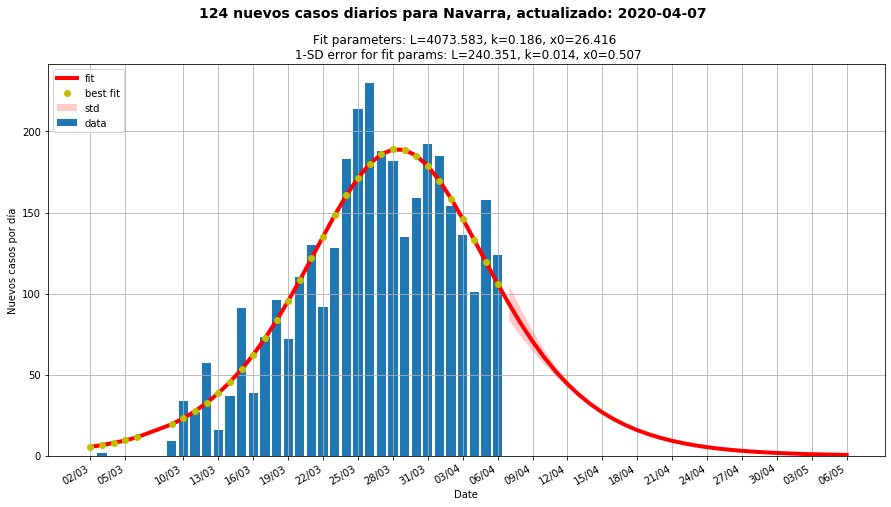

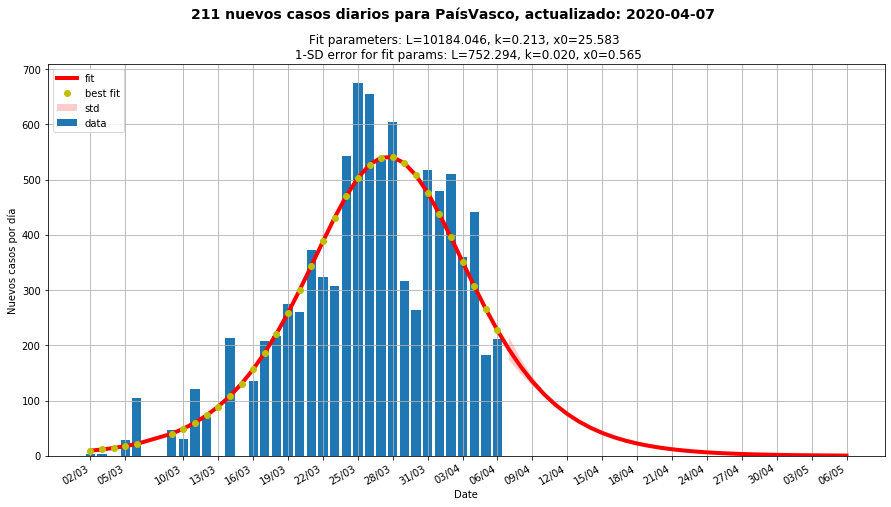

In [21]:
for CCAA in data.CCAA.unique():
    ConfirmedCCAA = data[data.CCAA==CCAA].casos.values
    datesCCAA = pd.to_datetime(data[data.CCAA=='Canarias'].fecha).to_numpy()
    
    #There was a gap on the reports in the 7/03 and 08/03
    ind=np.where( (datesCCAA != np.datetime64(datetime(2020, 3, 7))) & (datesCCAA != np.datetime64(datetime(2020, 3, 8))))   
    ConfirmedCCAA = ConfirmedCCAA[ind]
    datesCCAA = datesCCAA[ind]
    newCasesCCAA = np.diff(ConfirmedCCAA)

    
    Titulo = '{:.0f} nuevos casos diarios para {}, actualizado: {}'.format(newCasesCCAA[-1],CCAA,datesCCAA[-1].astype('datetime64[D]'))
    p_cont, err_cont = fit_curve(logistic_derivative, datesCCAA[:-1], newCasesCCAA, Titulo, 'Nuevos casos por día', coeff_std)